In [1]:
import os

import h5py
import numpy as np
import edpyt.utils.plotter as pl

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def compute_homo_lumo_gap(gfloc, energy_grid, plot_params=None, plot=False):
    """
    Computes the HOMO-LUMO gap from gfloc by finding the separation between the highest peak below the Fermi level 
    and the lowest peak above the Fermi level in the spectral function.

    Parameters:
        gfloc (np.ndarray): Array containing gfloc data with shape (n_impurities, n_energies).
        energy_grid (np.ndarray): Array of energy values corresponding to gfloc.
        plot_params (dict, optional): Dictionary of plot parameters to customize the plot appearance.

    Returns:
        dict: A dictionary containing the HOMO and LUMO energy values and the HOMO-LUMO gap for each impurity.
    """
    # Calculate spectral function: -(1/π) * Im(gfloc)
    spectral_function = -(1 / np.pi) * np.imag(gfloc)
    n_impurities = spectral_function.shape[0]

    # Initialize result dictionary
    homo_lumo_data = {}

    for i in range(n_impurities):
        spectrum = spectral_function[i]
        
        # Find indices of energy points below and above the Fermi level (0)
        below_fermi = energy_grid < 0
        above_fermi = energy_grid > 0

        # Identify the HOMO and LUMO peak positions
        homo_index = np.argmax(spectrum[below_fermi])
        lumo_index = np.argmax(spectrum[above_fermi]) + np.sum(below_fermi)

        homo_energy = energy_grid[below_fermi][homo_index]
        lumo_energy = energy_grid[above_fermi][lumo_index - np.sum(below_fermi)]
        homo_lumo_gap = lumo_energy - homo_energy

        # Store the results for this impurity
        homo_lumo_data[f"Impurity {i}"] = {
            "HOMO_energy": homo_energy,
            "LUMO_energy": lumo_energy,
            "HOMO_LUMO_gap": homo_lumo_gap,
        }
        
        if plot:
            # Optional plotting to visualize the spectral function and identified peaks
            if plot_params is None:
                plot_params = {}
            plt.figure(figsize=plot_params.get("figsize", (8, 4)))
            plt.plot(energy_grid, spectrum, label=f"Impurity {i}")
            plt.axvline(homo_energy, color="blue", linestyle="--", label="HOMO")
            plt.axvline(lumo_energy, color="red", linestyle="--", label="LUMO")
            plt.xlabel(plot_params.get("xlabel", "Energy"))
            plt.ylabel(plot_params.get("ylabel", r"$-\frac{1}{\pi} \mathrm{Im}(G_{loc})$"))
            plt.title(plot_params.get("title", f"Spectral Function and HOMO-LUMO for Impurity {i}"))
            plt.legend(loc=plot_params.get("legend_loc", "upper right"))
            plt.grid(plot_params.get("grid", True))
            plt.tight_layout()
            plt.show()

    return homo_lumo_data


In [ ]:
import os
import numpy as np

def process_all_gfloc(data_folder="output", plot=False):
    # Loop through each subfolder in the base directory
    results = {}
    for subfolder in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, subfolder)

        # Skip if not a directory
        if not os.path.isdir(folder_path):
            continue

        print(f"Processing folder: {subfolder}")

        # Load gfloc data and energy grid
        gfloc_file = os.path.join(folder_path, "dmft_gfloc.npy")
        if not os.path.exists(gfloc_file):
            print(f"No dmft_gfloc.npy file in {subfolder}, skipping...")
            continue

        gfloc = np.load(gfloc_file)
        eta = 3e-2
        energies = np.arange(-10, 10, 0.01)
        energy_grid = energies + 1.0j * eta  # Assuming this is the energy grid for the spectral function

        # Compute HOMO-LUMO gap and optionally plot
        plot_params = {
            "figsize": (8, 4),
            "xlabel": "Energy",
            "ylabel": r"$-\frac{1}{\pi} \mathrm{Im}(G_{loc})$",
            "legend_loc": "upper right",
            "grid": True,
        }
        homo_lumo_data = compute_homo_lumo_gap(gfloc, energy_grid.real, plot_params, plot=plot)

        # Store results for each subfolder
        results[subfolder] = homo_lumo_data
        print(f"HOMO-LUMO data for {subfolder}:")
        for impurity, data in homo_lumo_data.items():
            print(f"{impurity}: HOMO = {data['HOMO_energy']}, LUMO = {data['LUMO_energy']}, Gap = {data['HOMO_LUMO_gap']}")

    return results

# Run the function to process all folders and calculate HOMO-LUMO gaps
data_folder = "output"  # Specify your data folder
homo_lumo_results = process_all_gfloc(data_folder, plot=True)


In [4]:
def plot_all_quantities(data_folder="output"):
    # Loop through each subfolder in the base directory
    for subfolder in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, subfolder)

        if not os.path.isdir(folder_path):
            continue

        # Extract parameters from folder name
        parts = subfolder.split('_')
        nbaths = parts[1]
        U = parts[3]

        print(f"Processing folder: {subfolder} (nbaths={nbaths}, U={U})")

        # Set labels for impurities
        labels = ["N", "C(H)", "C(N)", "C(C)", "C(Radical)", "C(H)", "C(N)", "C(H)", "N"]

        # Default plot parameters to include nbaths and U in titles and labels
        default_plot_params = {
            "title": f"Plot for nbaths={nbaths}, U={U}",
            "legend_loc": "upper right",
            "grid": True,
        }

        try:
            # Load and plot delta
            delta_file = os.path.join(folder_path, "dmft_delta.npy")
            delta = np.load(delta_file)
            beta = 1000
            ne = delta.shape[1]
            z_mats = 1.0j * (2 * np.arange(ne) + 1) * np.pi / beta
            delta_plot_params = default_plot_params.copy()
            delta_plot_params["title"] = f"Delta (nbaths={nbaths}, U={U})"
            pl.plot_delta(delta, z_mats, labels=labels, plot_params=delta_plot_params)
        except Exception as e:
            print(f"Error plotting delta for {subfolder}: {e}")

        try:
            # Load and plot gfloc with specific xlim
            gfloc_file = os.path.join(folder_path, "dmft_gfloc.npy")
            gfloc = np.load(gfloc_file)
            eta = 3e-2
            energies = np.arange(-10, 10, 0.01)
            z_ret = energies + 1.0j * eta
            gfloc_plot_params = default_plot_params.copy()
            gfloc_plot_params.update({
                "title": f"Gfloc Spectral Function (nbaths={nbaths}, U={U})",
                "xlim": (-2.5, 2.5)
            })
            pl.plot_gfloc_spectral_function(gfloc, z_ret.real, labels=labels, plot_params=gfloc_plot_params)
        except Exception as e:
            print(f"Error plotting gfloc for {subfolder}: {e}")

        try:
            # Load and plot sigma trace with specific xlim
            sigma_file = os.path.join(folder_path, "dmft_sigma.npy")
            sigma = np.load(sigma_file)
            sigma_plot_params = default_plot_params.copy()
            sigma_plot_params.update({
                "title": f"Sigma Trace (nbaths={nbaths}, U={U})",
                "xlim": (-2.5, 2.5)
            })
            pl.plot_trace_sigma(sigma, z_ret, plot_params=sigma_plot_params)
        except Exception as e:
            print(f"Error plotting sigma for {subfolder}: {e}")

        try:
            # Load and plot charge per impurity
            charge_file = os.path.join(folder_path, "charge_per_orbital.npy")
            charge = np.load(charge_file)
            dmft_charge_file = os.path.join(folder_path, "charge_per_orbital_dmft.npy")
            dmft_charge = np.load(dmft_charge_file)
            charge_plot_params = default_plot_params.copy()
            charge_plot_params["title"] = f"Charge per Impurity (nbaths={nbaths}, U={U})"
            pl.plot_charge_per_impurity([charge, dmft_charge], labels=labels, dataset_labels=["Original", "DMFT"], plot_params=charge_plot_params)
        except Exception as e:
            print(f"Error plotting charge per impurity for {subfolder}: {e}")

        try:
            # Load and plot bath energies
            h5_file = os.path.join(folder_path, "dmft_iterations.h5")
            bath_energy_plot_params = default_plot_params.copy()
            bath_energy_plot_params["title"] = f"Bath Energies (nbaths={nbaths}, U={U})"
            pl.plot_bath_energies(h5_file, labels=labels, plot_params=bath_energy_plot_params)
        except Exception as e:
            print(f"Error plotting bath energies for {subfolder}: {e}")

        try:
            # Load and plot bath couplings
            bath_coupling_plot_params = default_plot_params.copy()
            bath_coupling_plot_params["title"] = f"Bath Couplings (nbaths={nbaths}, U={U})"
            pl.plot_bath_couplings(h5_file, labels=labels, plot_params=bath_coupling_plot_params)
        except Exception as e:
            print(f"Error plotting bath couplings for {subfolder}: {e}")


Processing folder: nbaths_4_U_4.0 (nbaths=4, U=4.0)


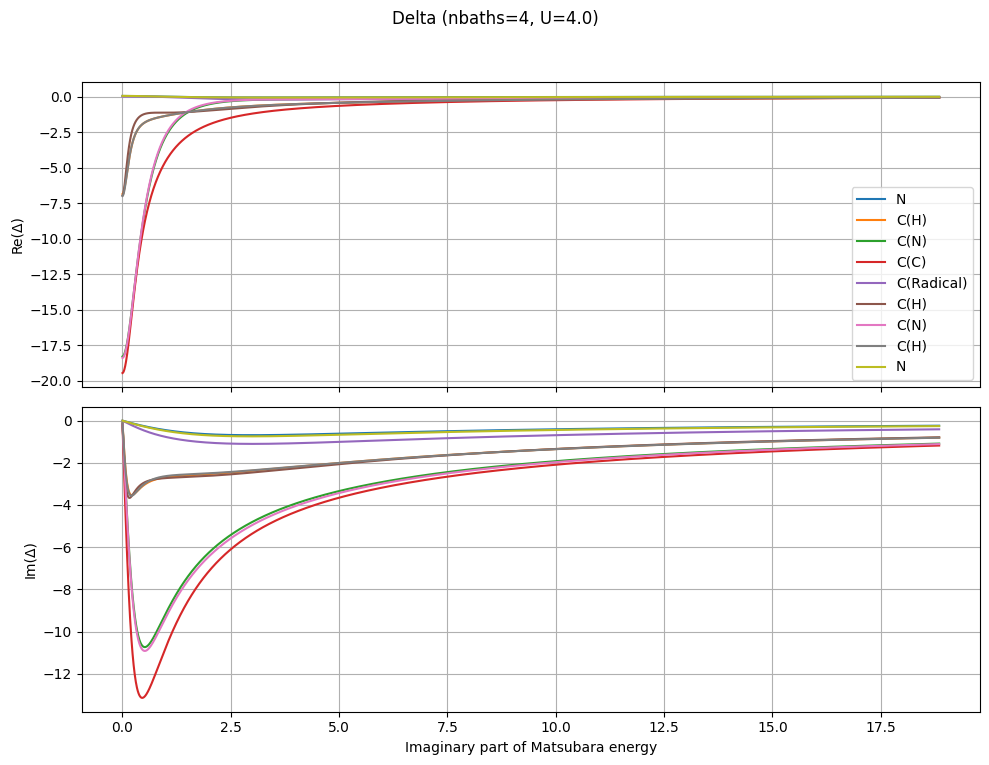

Processing folder: nbaths_8_U_6.0 (nbaths=8, U=6.0)


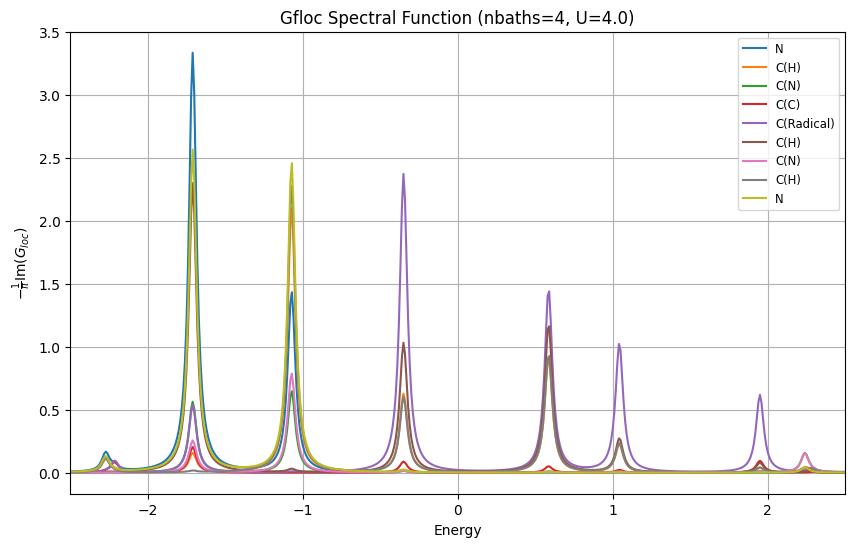

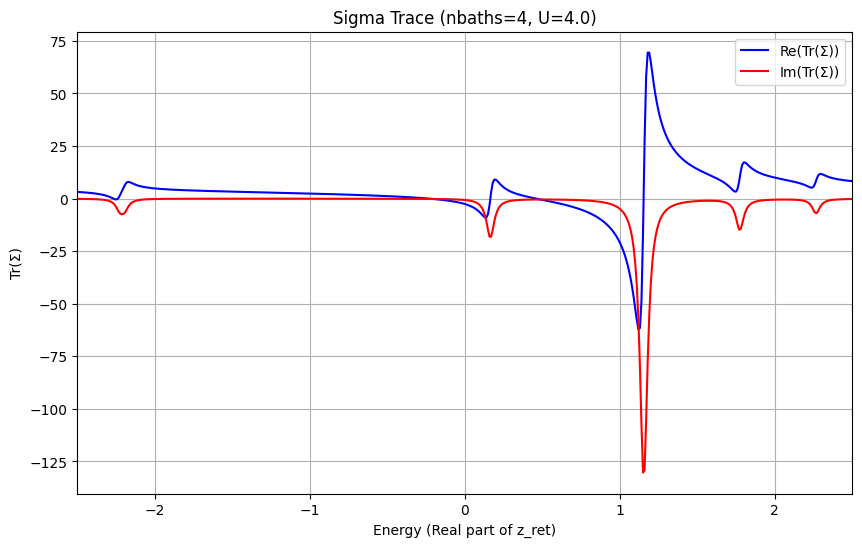

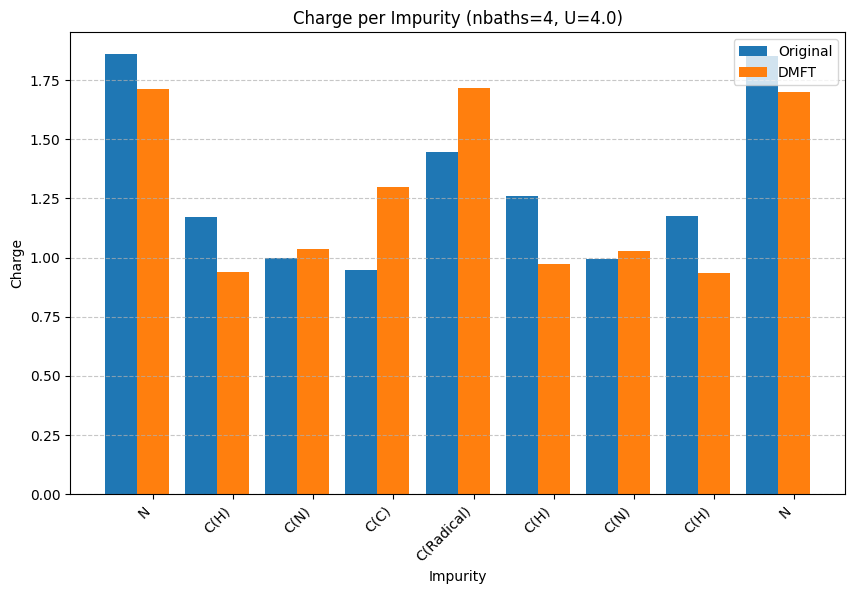

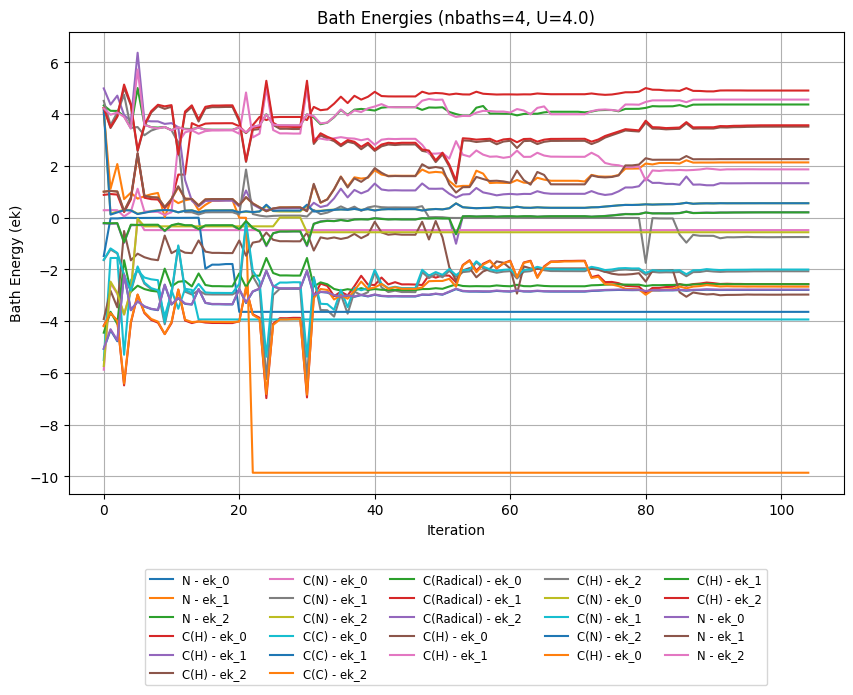

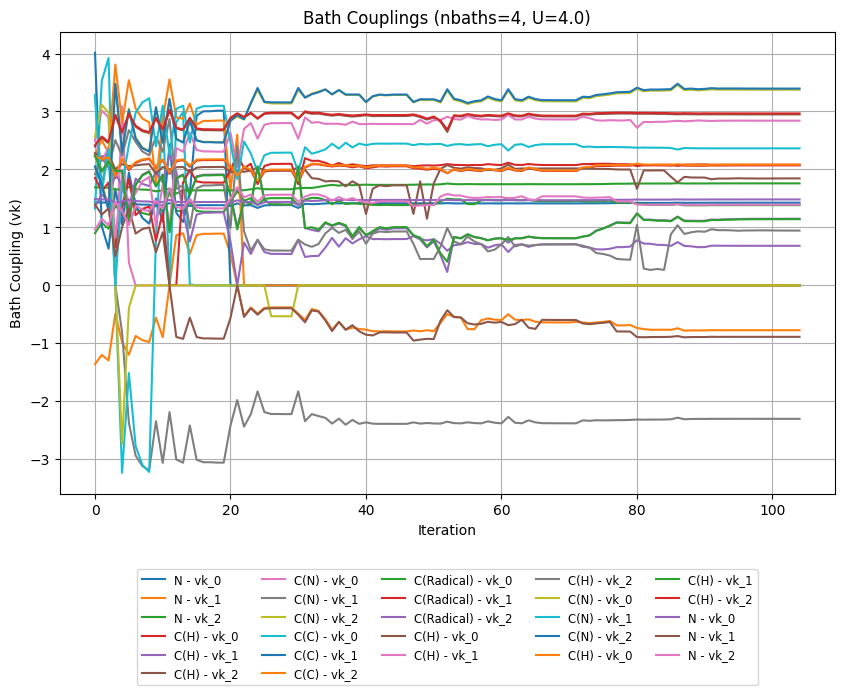

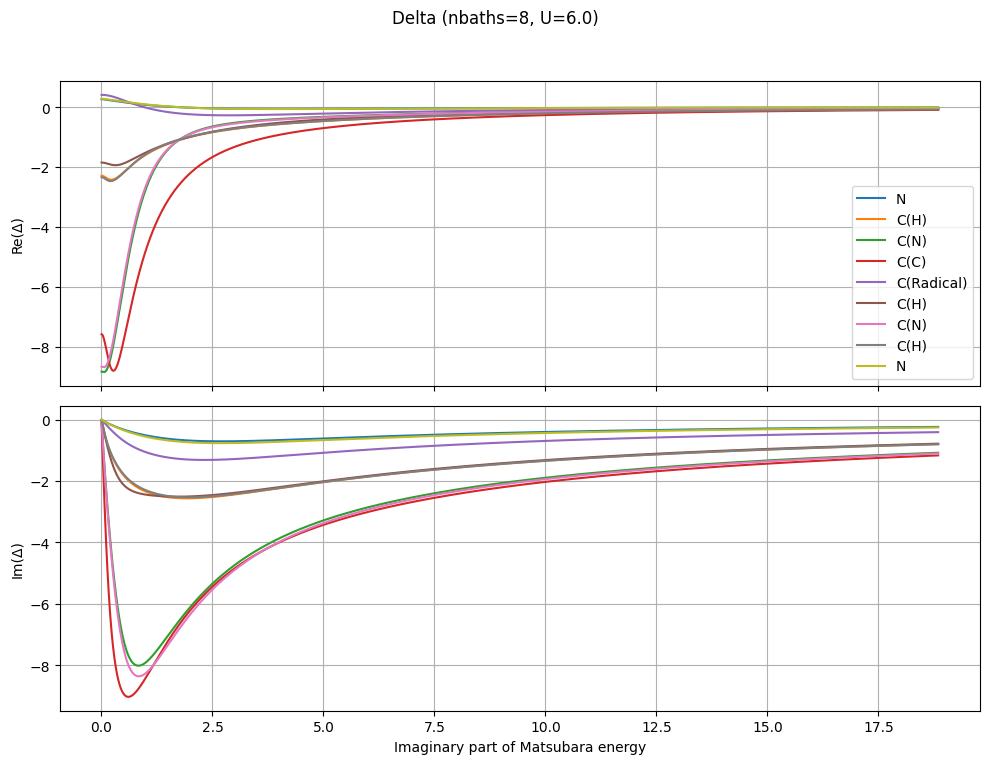

Processing folder: nbaths_8_U_4.0 (nbaths=8, U=4.0)


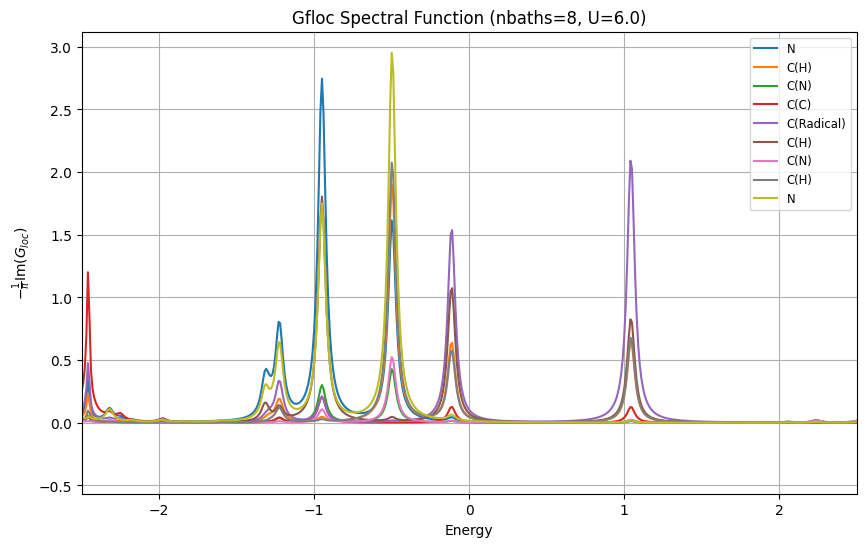

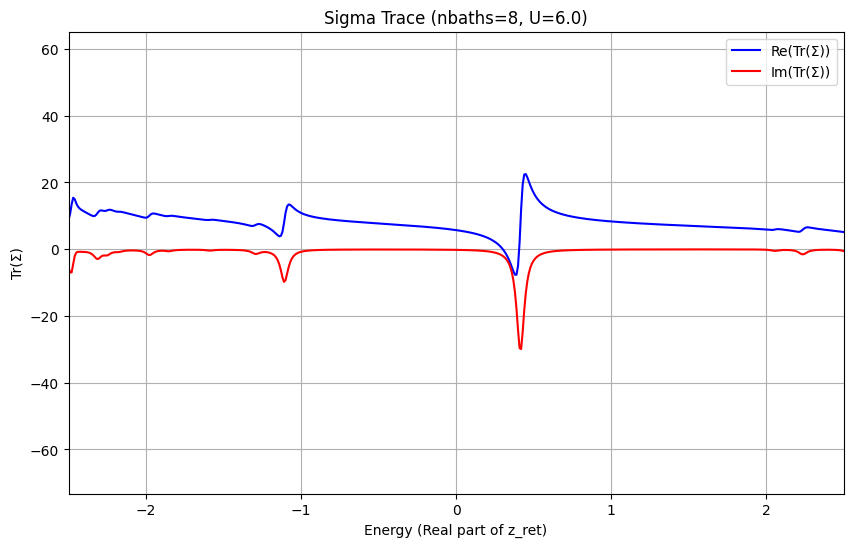

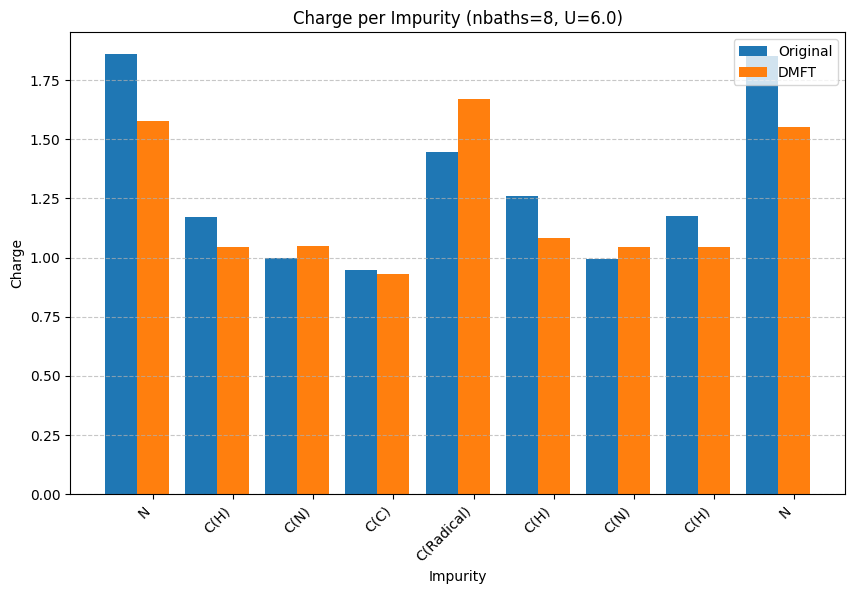

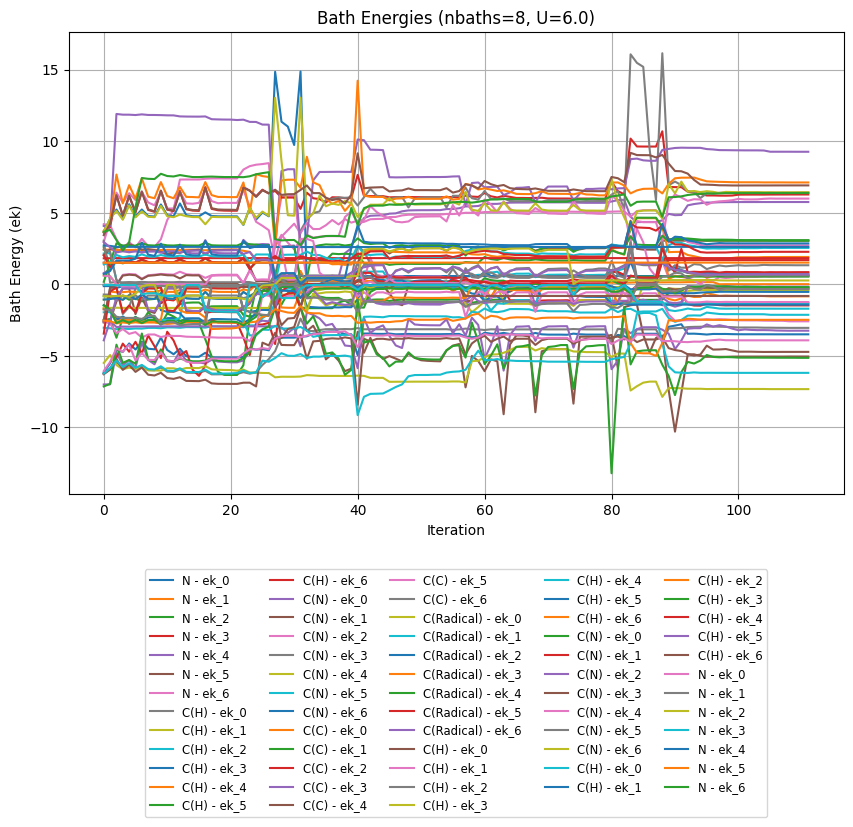

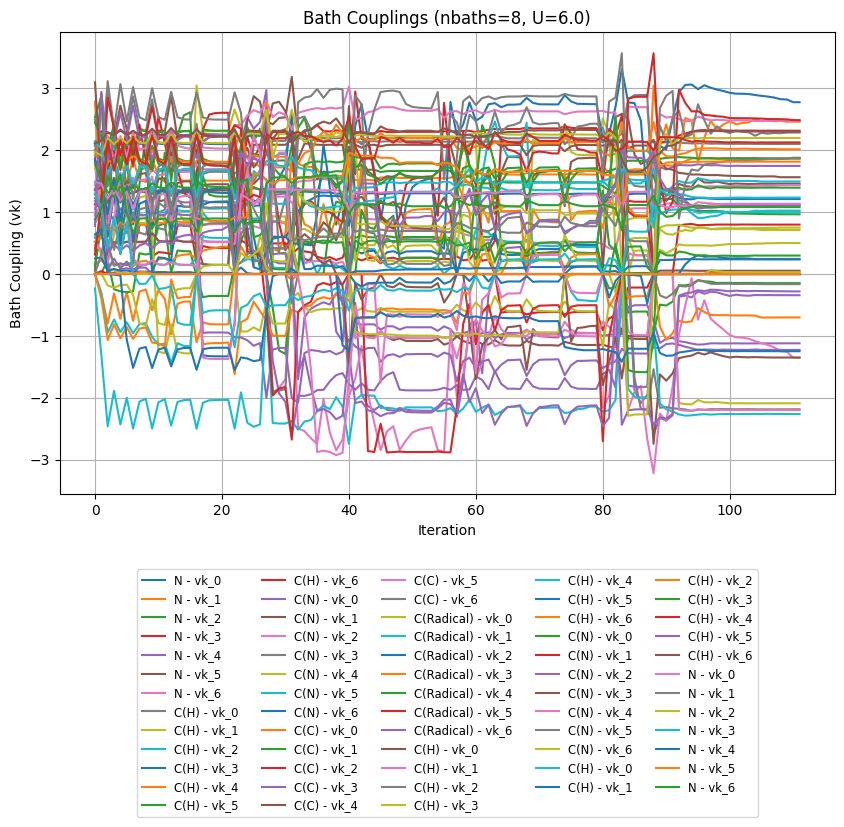

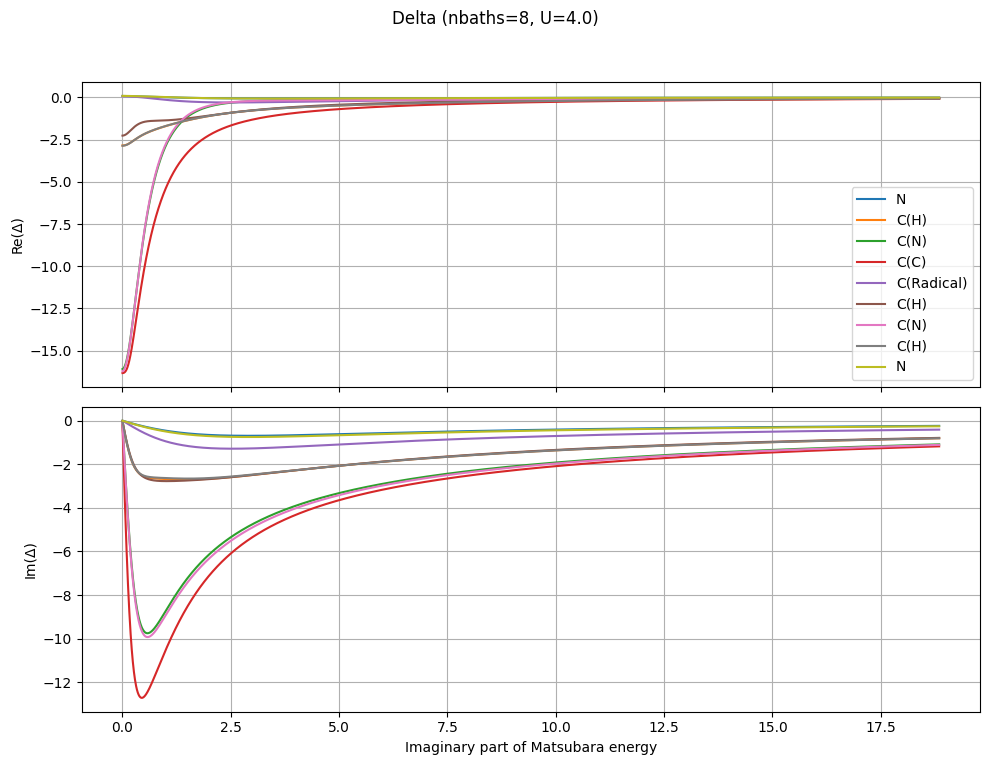

Processing folder: nbaths_4_U_5.0 (nbaths=4, U=5.0)


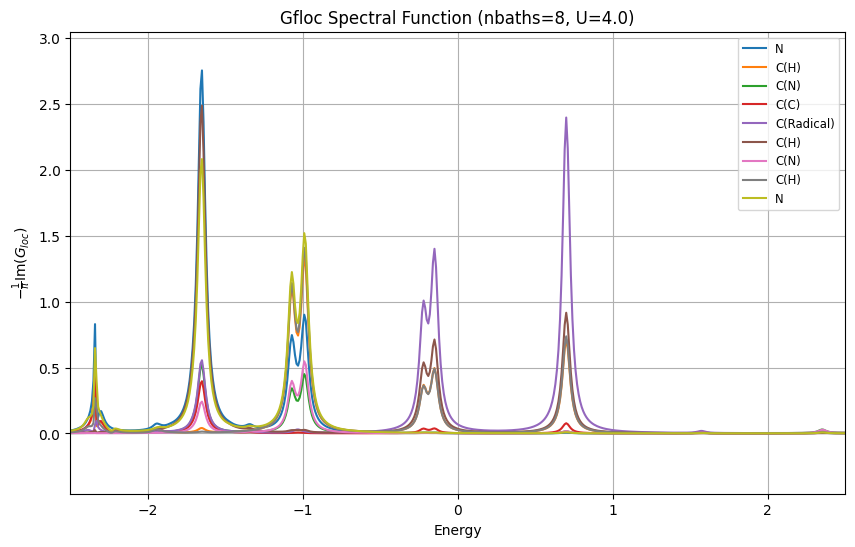

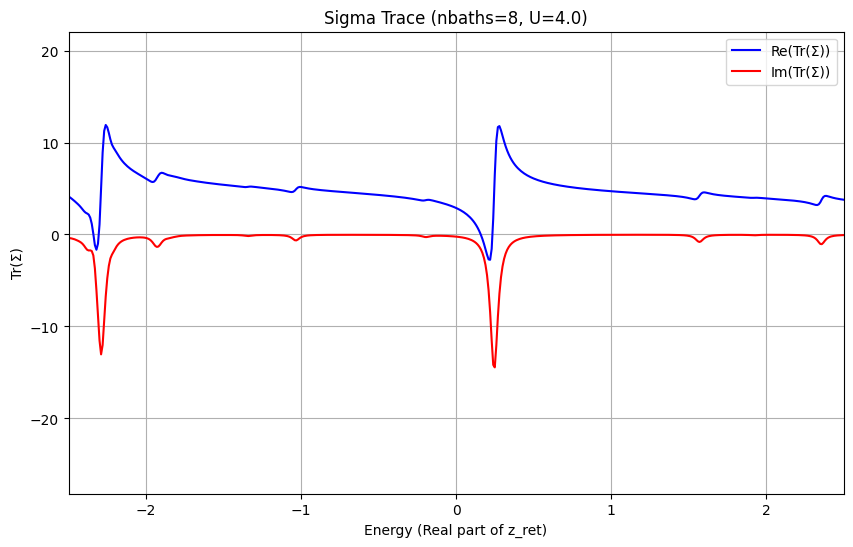

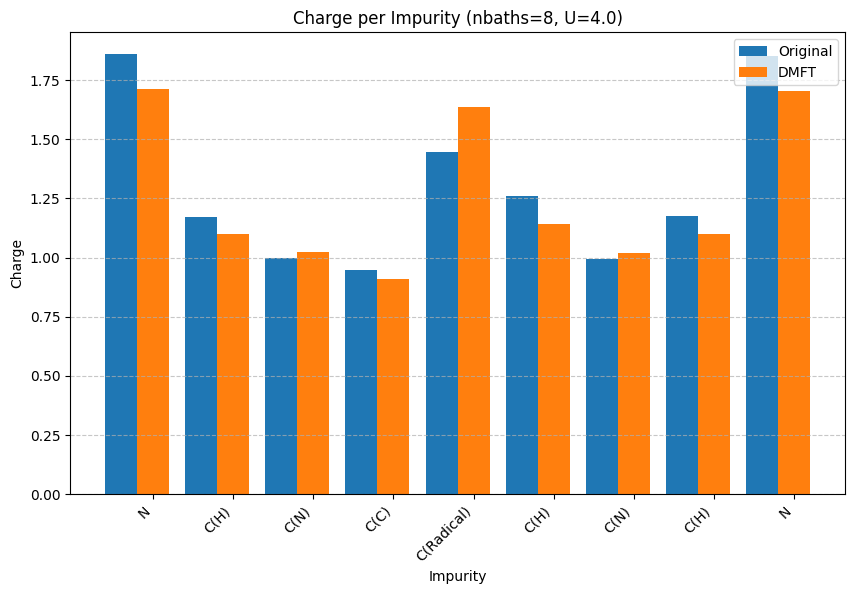

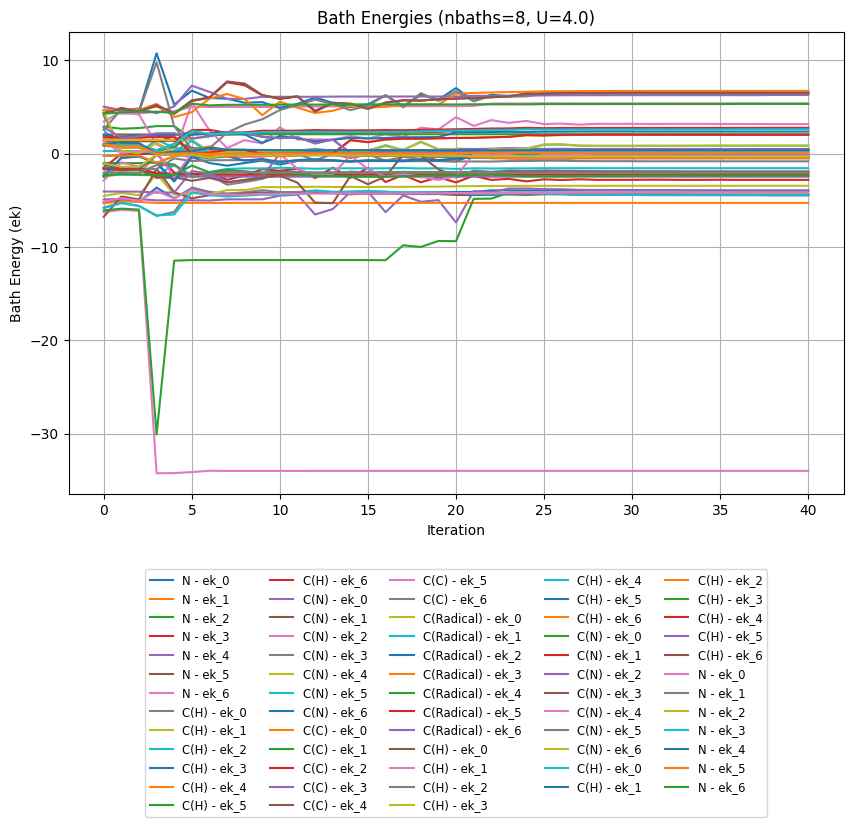

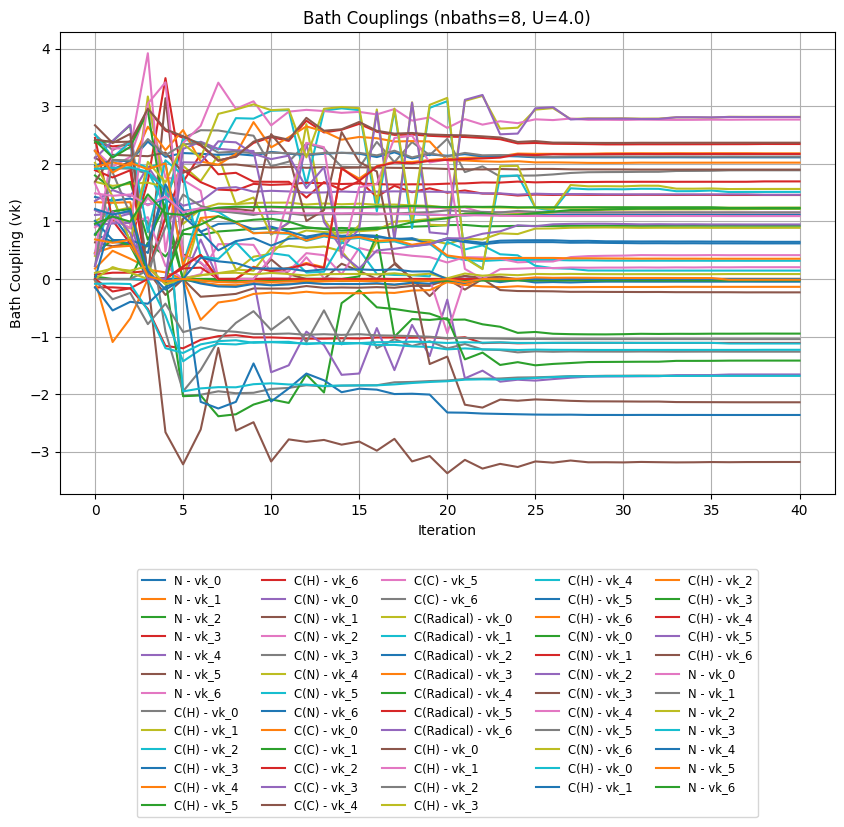

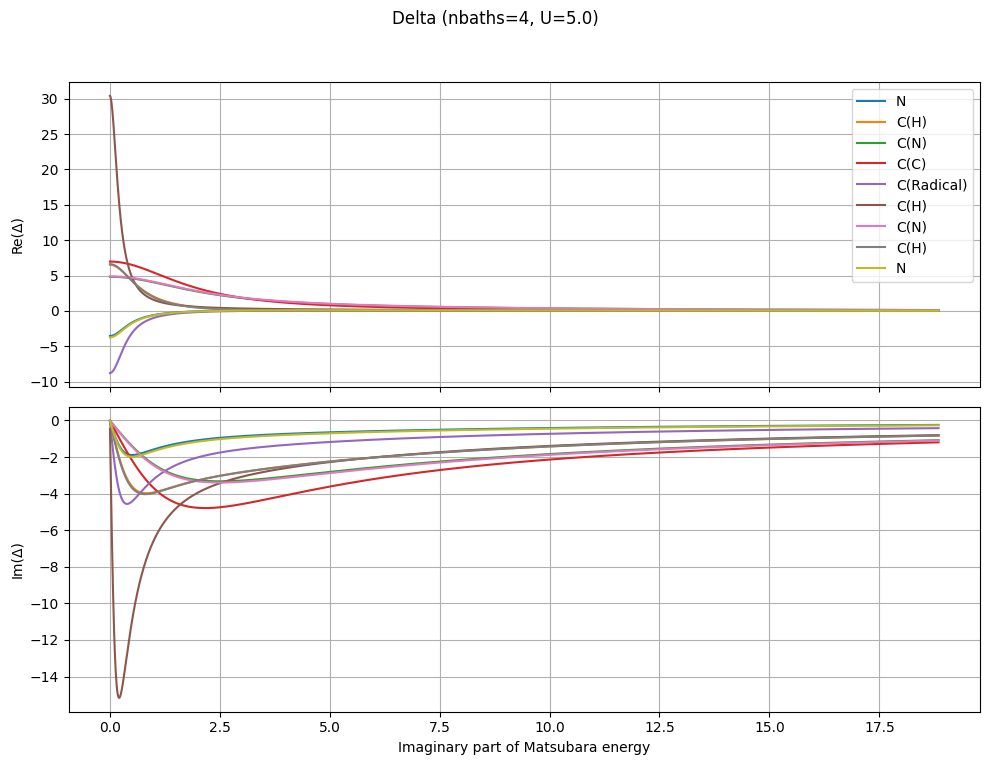

Processing folder: nbaths_8_U_5.0 (nbaths=8, U=5.0)


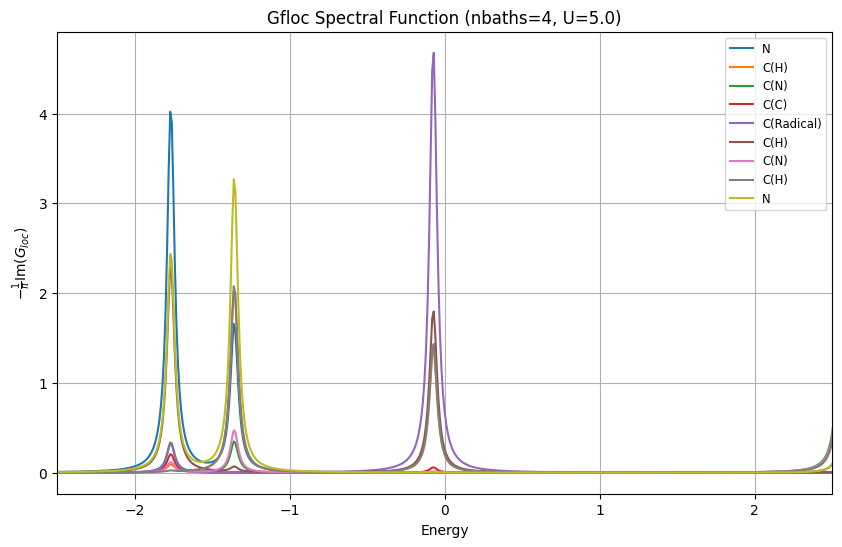

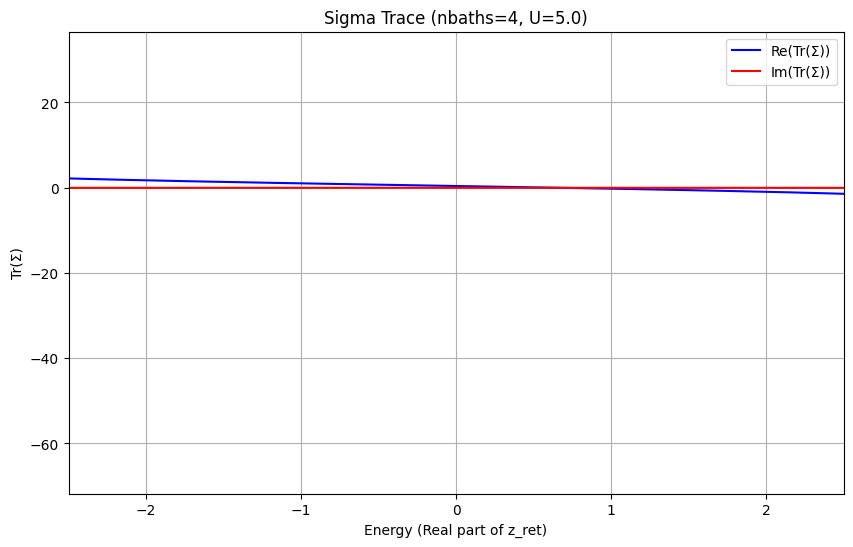

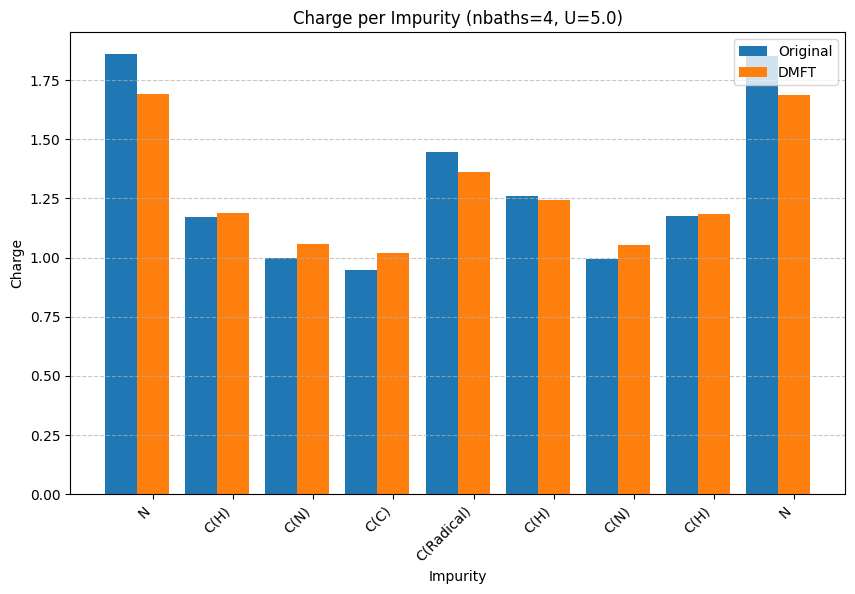

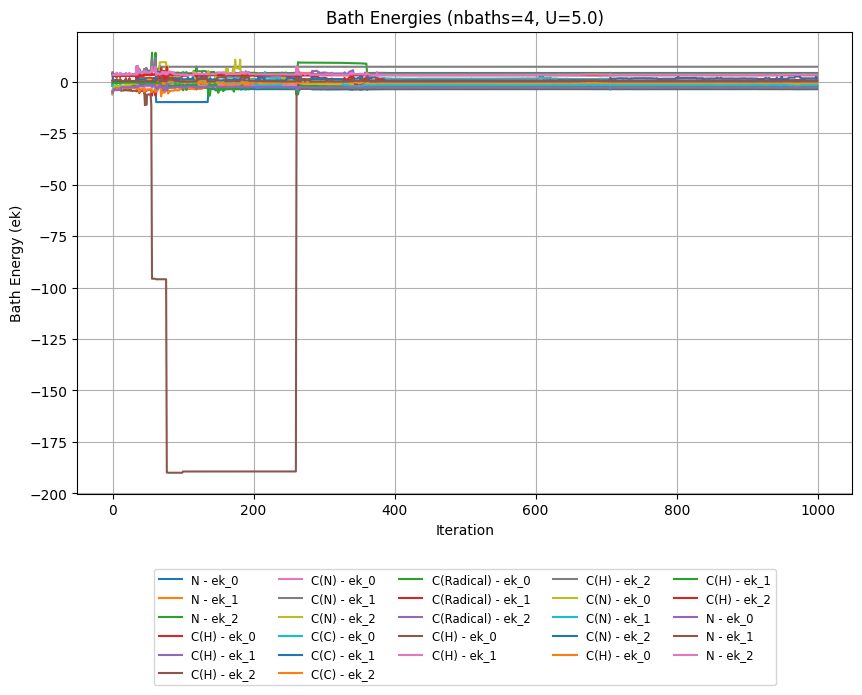

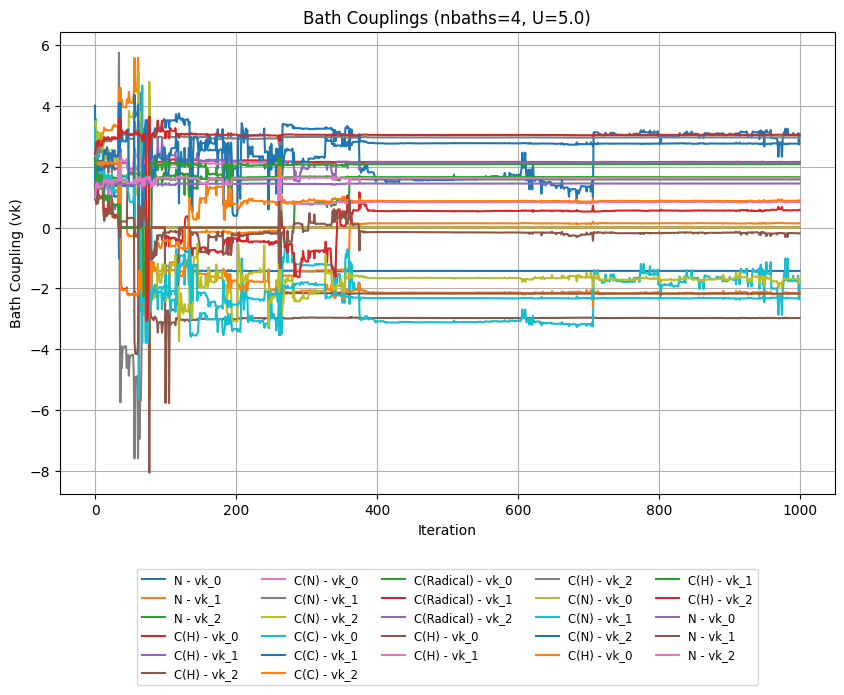

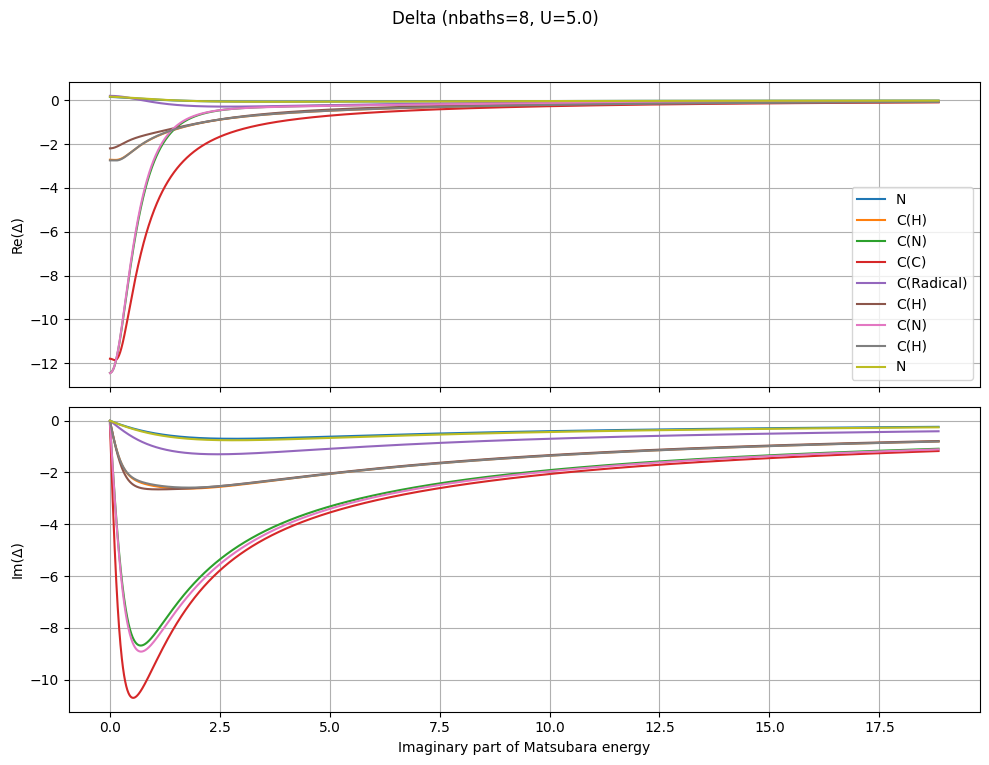

Processing folder: nbaths_4_U_6.0 (nbaths=4, U=6.0)
Error plotting delta for nbaths_4_U_6.0: [Errno 2] No such file or directory: 'output/compute_run/model/nbaths_4_U_6.0/dmft_delta.npy'
Error plotting gfloc for nbaths_4_U_6.0: [Errno 2] No such file or directory: 'output/compute_run/model/nbaths_4_U_6.0/dmft_gfloc.npy'
Error plotting sigma for nbaths_4_U_6.0: [Errno 2] No such file or directory: 'output/compute_run/model/nbaths_4_U_6.0/dmft_sigma.npy'
Error plotting charge per impurity for nbaths_4_U_6.0: [Errno 2] No such file or directory: 'output/compute_run/model/nbaths_4_U_6.0/charge_per_orbital.npy'


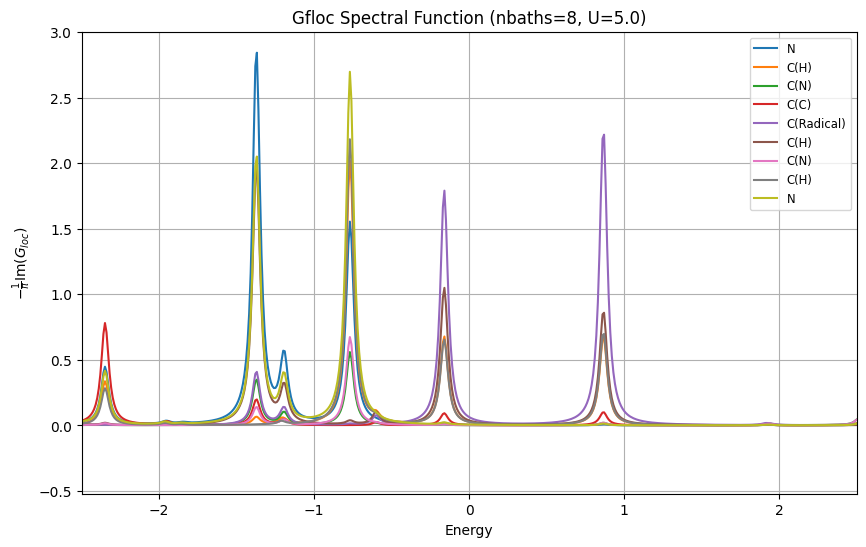

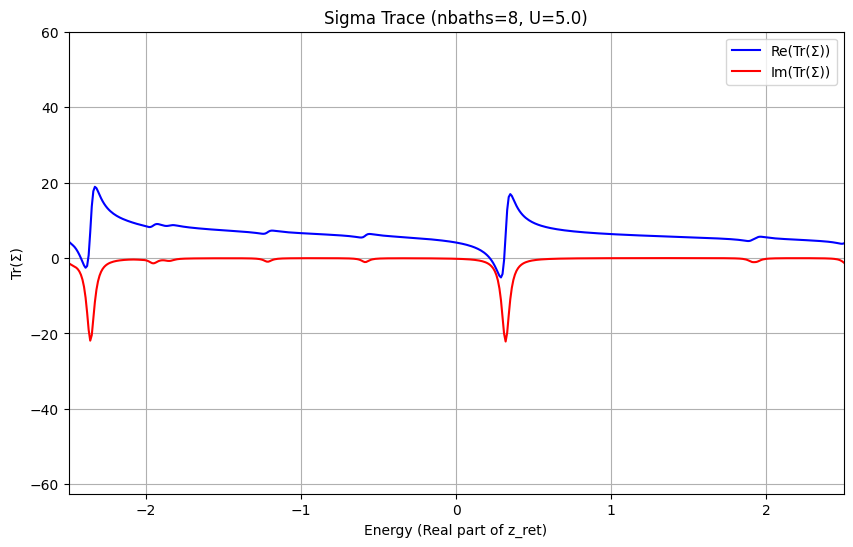

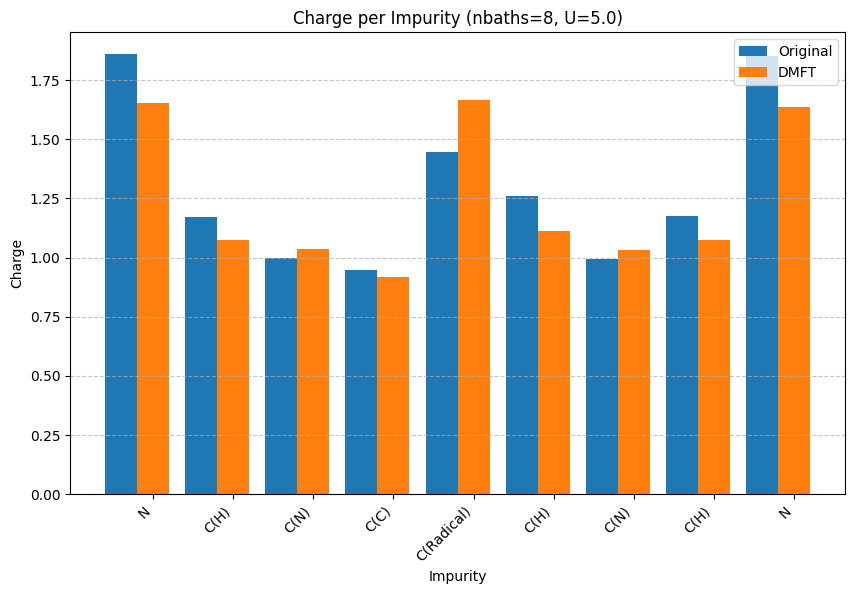

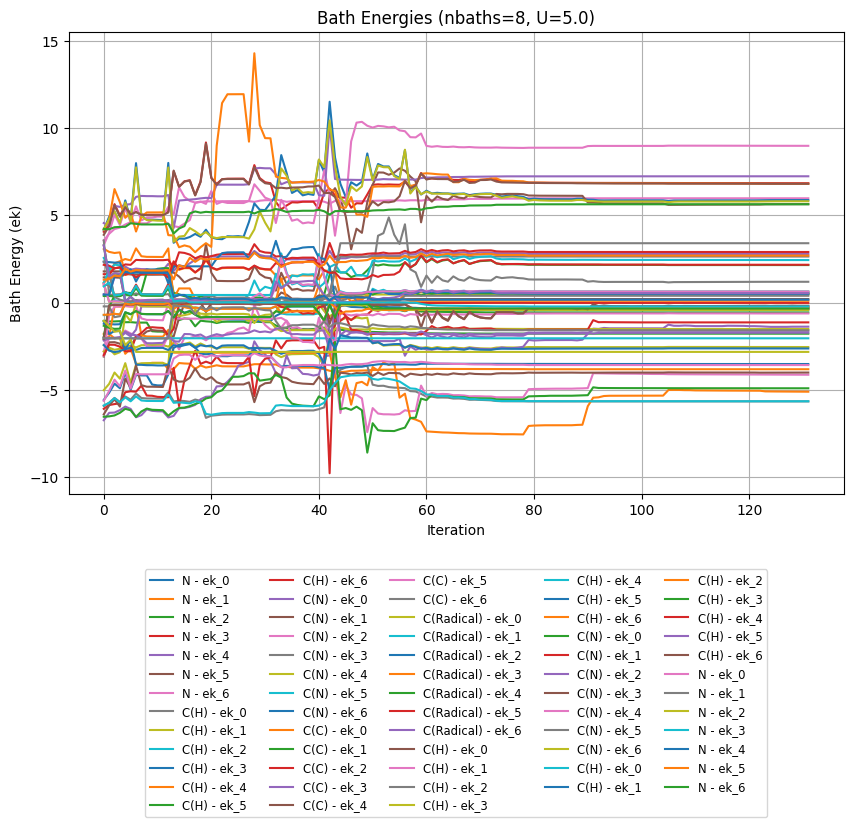

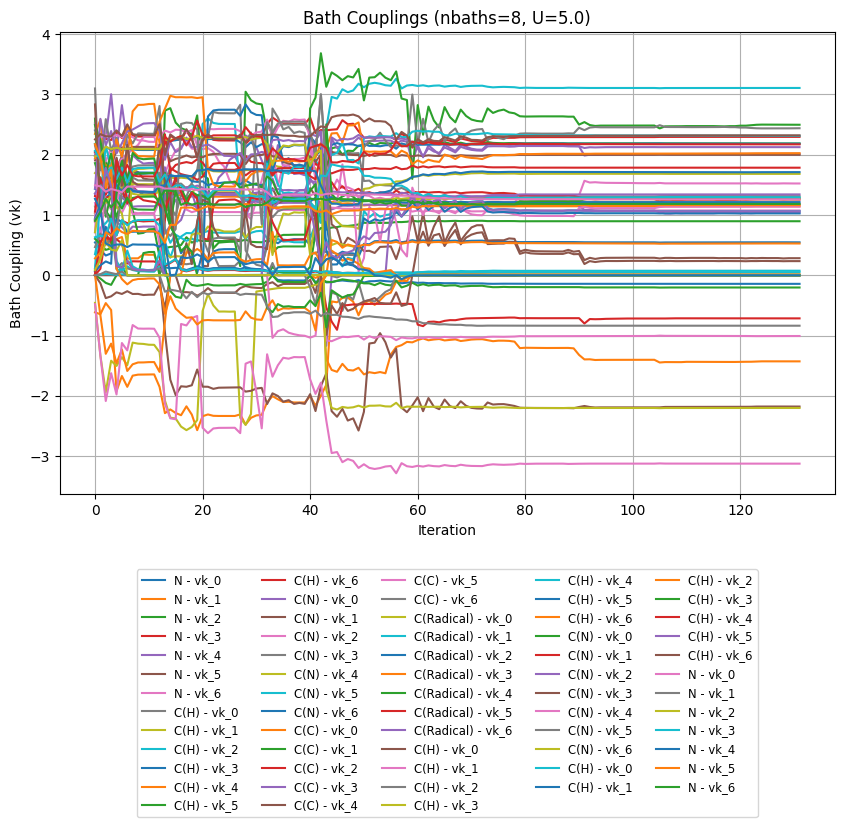

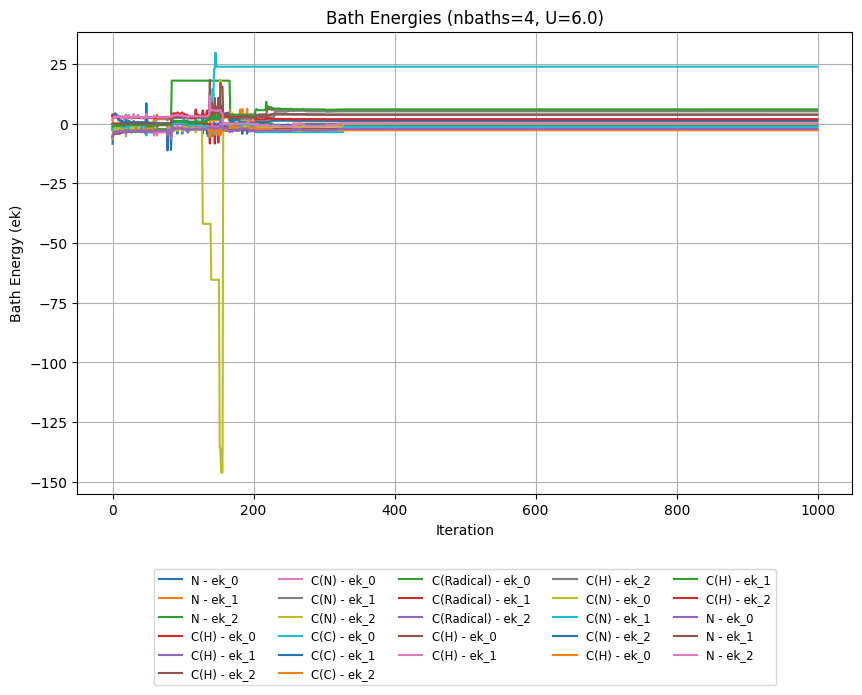

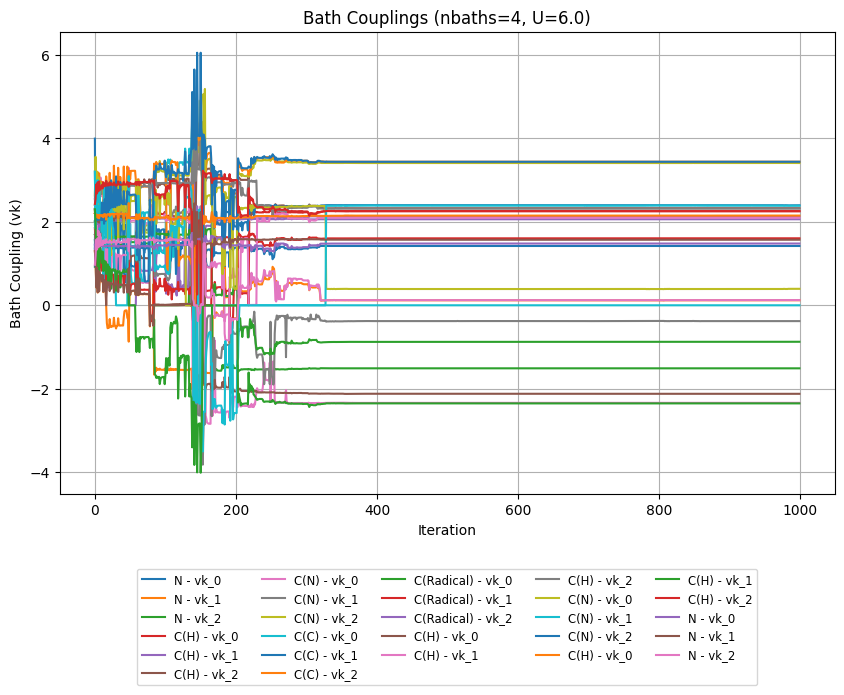

In [5]:
data_folder = "output/compute_run/model"
# Run the plotting function
plot_all_quantities(data_folder)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_all_quantities(data_folder="output"):
    # Gather all subfolders
    subfolders = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]

    # Extract unique nbath and U combinations
    param_combinations = []
    for subfolder in subfolders:
        parts = subfolder.split('_')
        nbaths = parts[1]
        U = parts[3]
        param_combinations.append((nbaths, U, subfolder))

    # Set labels for impurities
    labels = ["N", "C(H)", "C(N)", "C(C)", "C(Radical)", "C(H)", "C(N)", "C(H)", "N"]

    # Define figure layout based on the number of combinations
    n_columns = len(param_combinations)
    fig, axs = plt.subplots(6, n_columns, figsize=(5 * n_columns, 30))

    for idx, (nbaths, U, subfolder) in enumerate(param_combinations):
        folder_path = os.path.join(data_folder, subfolder)
        plot_params = {
            "title": f"nbaths={nbaths}, U={U}",
            "legend_loc": "upper right",
            "grid": True,
        }

        try:
            # Plot delta
            delta_file = os.path.join(folder_path, "dmft_delta.npy")
            delta = np.load(delta_file)
            beta = 1000
            ne = delta.shape[1]
            z_mats = 1.0j * (2 * np.arange(ne) + 1) * np.pi / beta
            plot_params["title"] = f"Delta (nbaths={nbaths}, U={U})"
            pl.plot_delta(delta, z_mats, labels=labels, plot_params=plot_params, ax=axs[0, idx])
        except Exception as e:
            print(f"Error plotting delta for {subfolder}: {e}")

        try:
            # Plot gfloc
            gfloc_file = os.path.join(folder_path, "dmft_gfloc.npy")
            gfloc = np.load(gfloc_file)
            eta = 3e-2
            energies = np.arange(-10, 10, 0.01)
            z_ret = energies + 1.0j * eta
            gfloc_plot_params = plot_params.copy()
            gfloc_plot_params.update({"title": f"Gfloc Spectral Function (nbaths={nbaths}, U={U})", "xlim": (-2.5, 2.5)})
            pl.plot_gfloc_spectral_function(gfloc, z_ret.real, labels=labels, plot_params=gfloc_plot_params, ax=axs[1, idx])
        except Exception as e:
            print(f"Error plotting gfloc for {subfolder}: {e}")

        try:
            # Plot sigma trace
            sigma_file = os.path.join(folder_path, "dmft_sigma.npy")
            sigma = np.load(sigma_file)
            sigma_plot_params = plot_params.copy()
            sigma_plot_params.update({"title": f"Sigma Trace (nbaths={nbaths}, U={U})", "xlim": (-2.5, 2.5)})
            pl.plot_trace_sigma(sigma, z_ret, plot_params=sigma_plot_params, ax=axs[2, idx])
        except Exception as e:
            print(f"Error plotting sigma for {subfolder}: {e}")

        try:
            # Plot charge per impurity
            charge_file = os.path.join(folder_path, "charge_per_orbital.npy")
            charge = np.load(charge_file)
            dmft_charge_file = os.path.join(folder_path, "charge_per_orbital_dmft.npy")
            dmft_charge = np.load(dmft_charge_file)
            charge_plot_params = plot_params.copy()
            charge_plot_params["title"] = f"Charge per Impurity (nbaths={nbaths}, U={U})"
            pl.plot_charge_per_impurity([charge, dmft_charge], labels=labels, dataset_labels=["Original", "DMFT"], plot_params=charge_plot_params, ax=axs[3, idx])
        except Exception as e:
            print(f"Error plotting charge per impurity for {subfolder}: {e}")

        try:
            # Plot bath energies
            h5_file = os.path.join(folder_path, "dmft_iterations.h5")
            bath_energy_plot_params = plot_params.copy()
            bath_energy_plot_params["title"] = f"Bath Energies (nbaths={nbaths}, U={U})"
            pl.plot_bath_energies(h5_file, labels=labels, plot_params=bath_energy_plot_params, ax=axs[4, idx])
        except Exception as e:
            print(f"Error plotting bath energies for {subfolder}: {e}")

        try:
            # Plot bath couplings
            bath_coupling_plot_params = plot_params.copy()
            bath_coupling_plot_params["title"] = f"Bath Couplings (nbaths={nbaths}, U={U})"
            pl.plot_bath_couplings(h5_file, labels=labels, plot_params=bath_coupling_plot_params, ax=axs[5, idx])
        except Exception as e:
            print(f"Error plotting bath couplings for {subfolder}: {e}")

    plt.tight_layout()
    plt.show()


Error plotting delta for nbaths_4_U_6.0: [Errno 2] No such file or directory: 'output/compute_run/model/nbaths_4_U_6.0/dmft_delta.npy'
Error plotting gfloc for nbaths_4_U_6.0: [Errno 2] No such file or directory: 'output/compute_run/model/nbaths_4_U_6.0/dmft_gfloc.npy'
Error plotting sigma for nbaths_4_U_6.0: [Errno 2] No such file or directory: 'output/compute_run/model/nbaths_4_U_6.0/dmft_sigma.npy'
Error plotting charge per impurity for nbaths_4_U_6.0: [Errno 2] No such file or directory: 'output/compute_run/model/nbaths_4_U_6.0/charge_per_orbital.npy'


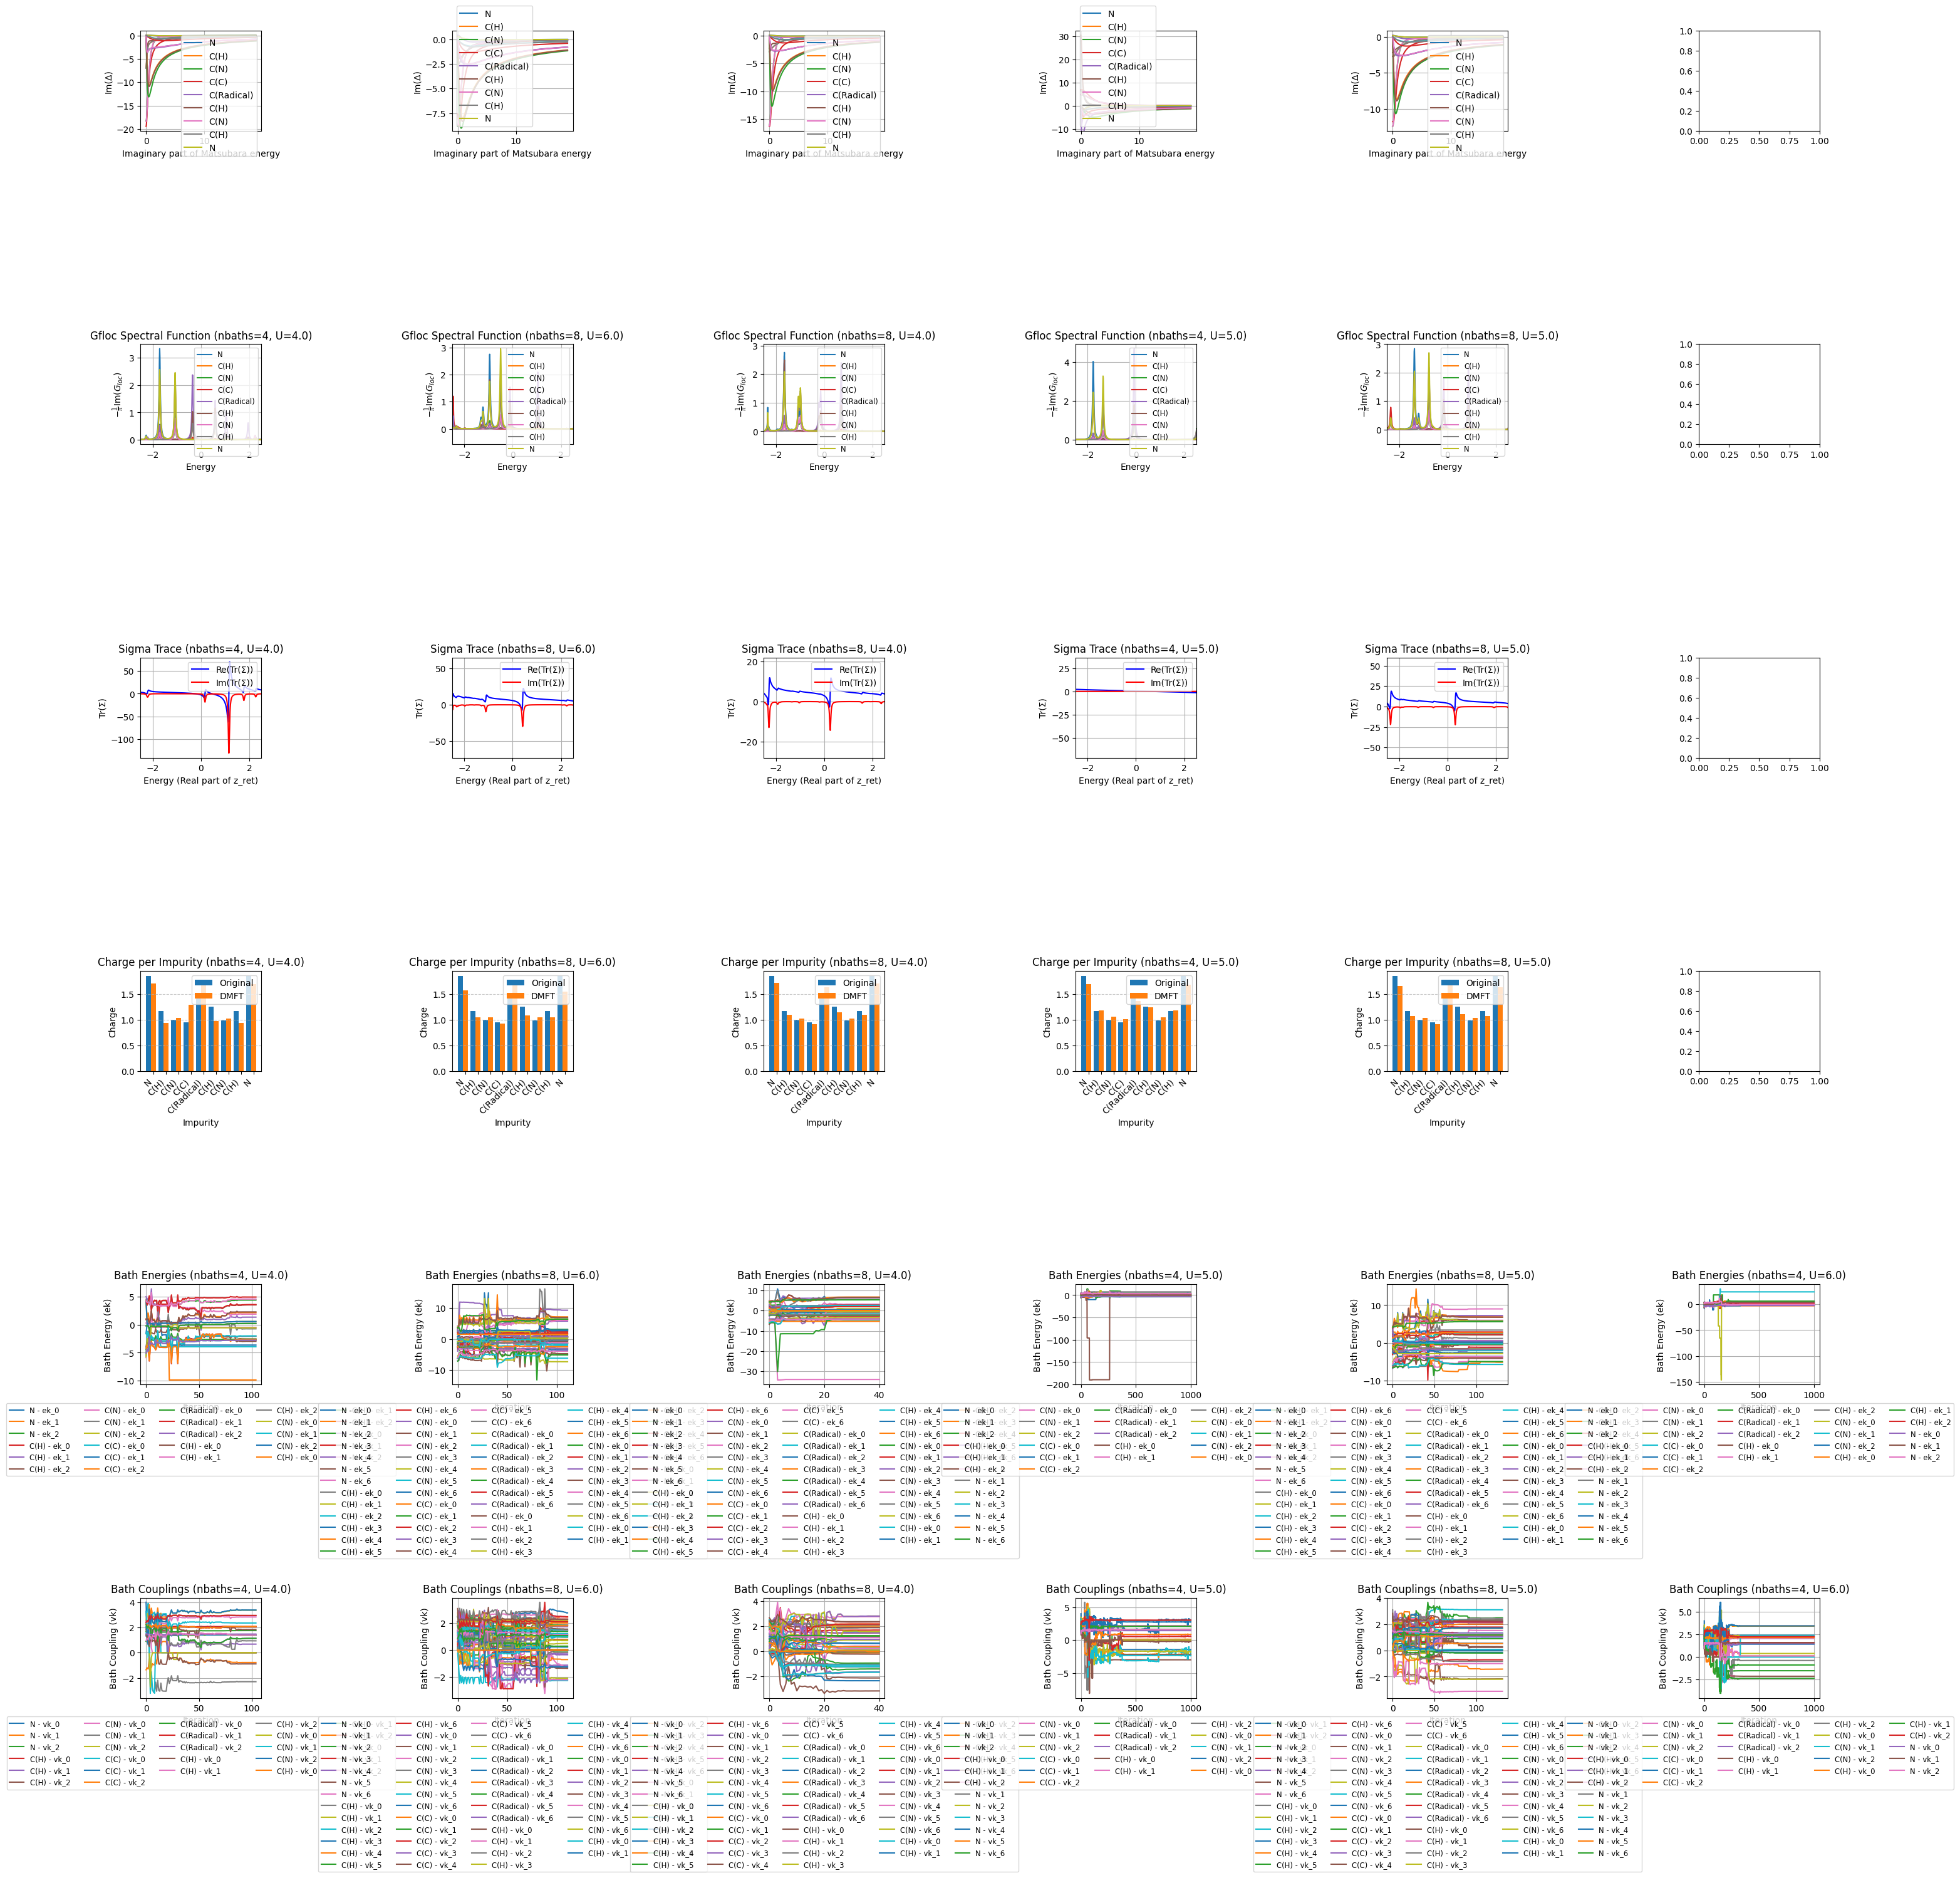

In [3]:
data_folder = "output/compute_run/model"
# Run the plotting function
plot_all_quantities(data_folder)